Epoch 1/25
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - R2Score: -0.1053 - loss: 0.7898 - mae: 0.3487 - root_mean_squared_error: 0.4092 - val_R2Score: -0.0016 - val_loss: 0.6210 - val_mae: 0.3430 - val_root_mean_squared_error: 0.3923
Epoch 2/25
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - R2Score: -0.0028 - loss: 0.6194 - mae: 0.3457 - root_mean_squared_error: 0.3924 - val_R2Score: -7.9310e-04 - val_loss: 0.6208 - val_mae: 0.3441 - val_root_mean_squared_error: 0.3922
Epoch 3/25
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - R2Score: -0.0015 - loss: 0.6171 - mae: 0.3439 - root_mean_squared_error: 0.3912 - val_R2Score: -6.8498e-04 - val_loss: 0.6207 - val_mae: 0.3443 - val_root_mean_squared_error: 0.3922
Epoch 4/25
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - R2Score: -0.0018 - loss: 0.6190 - mae: 0.3461 - root_mean_squared_error: 0.3925 - val_R2Score: -0.0043 - val_loss: 0.6221 - val_mae: 0.3407 - val_root_mean_squared_error: 0.3929
Epoch 5/25
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step -

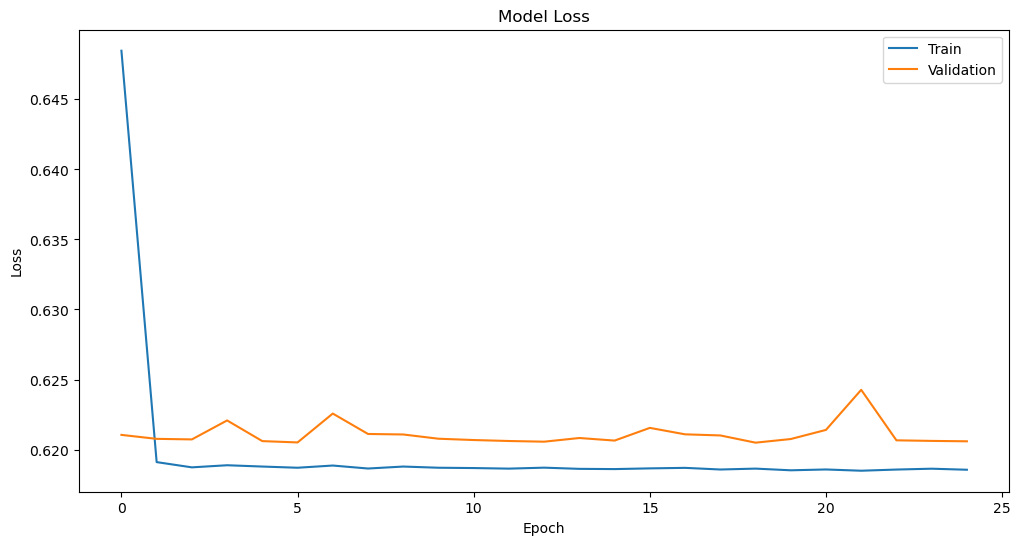

In [3]:
#LOGAN KELSCH
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD
from keras.initializers import GlorotUniform

tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------
# 3.0 collected data features:
# Symbol: /ES:XCME
# Work Time: 4/10/23, 3:05 PM - 9/13/24, 1:55 PM
# fulltime- seconds since 1970 (for appending data)
# FullK-    fullK plot for Stochastic of past hour
# diffKD-   value difference between fullK/fullD of past hour
# OB , OS-  boolean if Stoch plots are in top/btm 20% of range
# vol-      trade volume of each bar
# s15,30,60-Current price/time slope of past n minutes 
#ToD-       Time of Day in seconds
#perc30,60- percentile of low and high of past 30,60 mins and day
#RSI-       RSI output of past hour
#Wpercent-  William Percent output of past hour
#acc-       Rate of acceleration of past hour over half hours
################################
#DESIRED OUTPUTS
#Are formulated by making a bull and bear 0-1 oscillator
#standard deviations derived from upcoming 4 hours of movement
#Value description:
#If value==0
#  the conditions are not appealing for next n minutes
#If value==1
#  the price moves >=1 std. dev. in that direciton for next n mins
#else
#  price moves y std. dev. in that direction for next n minutes
#bull/bear15 - 15 minute direction lookahead
#bull/bear30 - 30 minute direction lookahead
#bull/bear60 - 60 minute direction lookahead

# Load the dataset
data = pd.read_csv('ES_5m_4-10-23_to_9-13-24.csv')


#testing random feature drops
#data = data.drop(columns='fullTime')
#data = data.drop(columns='FullK')
#data = data.drop(columns='diffKD')
#data = data.drop(columns='OB')
#data = data.drop(columns='OS')
#data = data.drop(columns='vol')
#data = data.drop(columns='s15')
#data = data.drop(columns='s30')
#data = data.drop(columns='s60')
#data = data.drop(columns='ToD')
#data = data.drop(columns='perc30')
#data = data.drop(columns='perc60')
#data = data.drop(columns='percD')
#data = data.drop(columns='RSI')
#data = data.drop(columns='Wpercent')
#data = data.drop(columns='acc')


#TEMP DROP PRE-DUAL-OUTPUT NN

#data = data.drop(columns='bull15')
data = data.drop(columns='bear15')

data = data.drop(columns='bull30')
data = data.drop(columns='bear30')

data = data.drop(columns='bull60')
data = data.drop(columns='bear60')

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#PROCESS THE DATA-------------------------------------------------------

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

opt1 = SGD(learning_rate=0.01)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.8)

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=GlorotUniform()),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.Dropout(0.9),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=GlorotUniform()),       
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    
    rmse='root_mean_squared_error'

    model.compile(optimizer=opt2, loss='binary_crossentropy', metrics=['mae','R2Score',rmse])
    return model

#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 25

model = build_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=1, shuffle=True)

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

#R and R^2 calculation attempt in the 3 lines below this

#unexplained_error = tf.reduce_sum(tf.square(tf.sub(y, y_pred)))
#total_error = tf.reduce_sum(tf.square(tf.sub(y, tf.reduce_mean(y))))
#R_squared = tf.sub(1, tf.div(unexplained_error, total_error))

#print(f"R^2: {R_squared}")

# ^ need to figure out how to fit a "prediction" variable into first line of this calculation
#or just use a tensorflow_addon rsquared formula to calculate this

#online source suggests that loss < .22 and R^2 over .9 is good
#on a good pace for truly building something here

#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Save the model
model.save('my_model.keras')
# Load the model
loaded_model = tf.keras.models.load_model('my_model.keras')

In [6]:
''' Testing outputs for model (placed here so we don't have to retrain)'''
preds = model.predict(X_train)
print(preds[0:5])
print(preds[10000:10005])

model.summary()


2543/2543 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
[[0.3048056]
 [0.3048056]
 [0.3048056]
 [0.3048056]
 [0.3048056]]
[[0.3048056]
 [0.3048056]
 [0.3048056]
 [0.3048056]
 [0.3048056]]


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,629 (1.57 MB)

 Trainable params: 136,705 (534.00 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 273,412 (1.04 MB)